# Eigenvalues of interval neutrino mixing matrices

The following notebook presents a method of bounding eigenvalues of interval neutrino mixing matrices by Rohn criterion (https://hal.inria.fr/inria-00370603/document).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/wujekanimator/neutrino_matrices/blob/main/rohn_bounds.ipynb)

In [57]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#tqdm().pandas()
pd.set_option('display.max_colwidth', -1)

Let's define an auxiliary function, that takes (symmetric matrix) intervals and generates the eigenvalues of center matrix, spectrum of a delta matrix and Rohn bounds:

In [41]:
def interval_matrix_bounds(intervals):
    
    '''takes the interval matrix - intervals - and returns eigenvalues 
    of a symmetric center matrix and spectrum of a delta matrix, 
    together with intervals of allowed eigenvalues of the interval matrix'''
    
    dimension = int(np.sqrt(len(intervals)))
    
    a_c = [1/2*(interval[1]+interval[0]) for interval in intervals] # center matrix for each interval matrix
    a_c_T = np.transpose(np.reshape(a_c, (dimension,dimension))) # transpose the center matrix
    a_c_T = [item for sublist in a_c_T for item in sublist] # flatten nested a_c_T
    a_c_prime = [1/2*(x1+x2) for (x1,x2) in zip(a_c, a_c_T)] # make a symmetric center matrix
    
    eigs_a_c_prime = np.sort(np.abs(np.linalg.eigvals(np.reshape(a_c_prime,(dimension,dimension))))) # sorted eigenvalues
    
    a_delta = [1/2*(interval[1]-interval[0]) for interval in intervals] # delta matrix
    a_delta_T = np.transpose(np.reshape(a_delta, (dimension,dimension))) # transpose the delta matrix
    a_delta_T = [item for sublist in a_delta_T for item in sublist] # flatten
    a_delta_prime = [1/2*(x1+x2) for (x1,x2) in zip(a_delta, a_delta_T)] # symmetric delta matrix
    
    spec_a_delta_prime = max(np.abs(np.linalg.eigvals(np.reshape(a_delta_prime,(3,3))))) # spectral radius of a_delta_prime
    
    rohn_bounds = [[round(item - spec_a_delta_prime, 4), round(item + spec_a_delta_prime, 4)] for
                       item in eigs_a_c_prime]
    
    return eigs_a_c_prime, spec_a_delta_prime, rohn_bounds

Now we need the experimental mixing matrix; we use the $\eta$-representation (https://arxiv.org/pdf/1605.08774.pdf)

In [42]:
#intervals_eta = [[-0.0013, 0.0013], [-0.000012,0.000012], [-0.0014,0.0014],[-0.000012,0.000012], [-0.00022,0.00022], [-0.0006,0.0006],
#                  [-0.0014,0.0014], [-0.0006,0.0006], [-0.0028,0.0028]]
intervals_eta = [[-0.0014, 0.0014], [-0.000013,0.000013], [-0.0015,0.0015],[-0.000013,0.000013], [-0.00023,0.00023], [-0.0007,0.0007],
                  [-0.0015,0.0015], [-0.0007,0.0007], [-0.0029,0.0029]]

It follows that our matrix dimension will be

In [43]:
n = int(np.sqrt(len(intervals_eta)))

Now we define widths of intervals, that will be drawn from above - all widths are scaled to the precision of given element:

In [44]:
interval_widths = [0.0001, 0.000001, 0.0001, 0.000001, 0.00001, 0.0001,0.0001, 0.0001, 0.0001]

We need to subtract ```intervals_eta``` from an identity, hence

In [45]:
double_identity = [[item,item] for item in np.identity(n).flatten()]
intervals_1_eta = double_identity + np.array(intervals_eta)
intervals_1_eta = [[item[1],item[0]] for item in intervals_1_eta]

Now we prepare lists for: 1) eigenvalues of center matrices $M_C$, 2) spectra of delta-matrices $M_{\Delta}$, 3) allowed intervals of eigenvalues and finally 4) drawn intervals:

In [46]:
a_c_all_eigs = []
spectra = []
rohn_bounds = []
intervals = [] 

Let's decide on how many matrices will be drawn:

In [60]:
range_i = 10000

Now we draw ```range_i```-many interval matrices, for each matrix we calculate the eigenvalues (Rohn) bounds

In [61]:
for i in tqdm(range(1,range_i)):
    # first we randomly pick narrow bounds for interval matrix
    bounds = []
    # indices for making a symmetric interval matrix
    indices = [0,1,2,1,3,4,2,4,5]
    i=0
    for item in intervals_1_eta:
        bound = np.random.uniform(low=item[0], high=item[1])
        bounds.append([bound, bound + interval_widths[i]])
        i+=1
    
    bounds = [bounds[i] for i in indices]
    intervals.append(bounds)
    a_c_all_eigs.append(np.abs(interval_matrix_bounds(bounds)[0]))
    spectra.append(interval_matrix_bounds(bounds)[1])
    rohn_bounds.append(interval_matrix_bounds(bounds)[2])

100%|██████████| 9999/9999 [00:17<00:00, 556.94it/s]


We form a dataframes of center matrix eigenvalues and Rohn bounds from above loop:

In [62]:
a_c_all_eigs_df = pd.DataFrame(a_c_all_eigs, columns=['eigenvalue_1',
                                                      'eigenvalue_2',
                                                      'eigenvalue_3'])
rohn_bounds_df = pd.DataFrame(rohn_bounds, columns=['interval_1',
                                                    'interval_2',
                                                    'interval_3'])

Let's add also the column with an explicit matrix elements:

In [63]:
rohn_bounds_df['matrix'] = [[[round(item,4) for item in item2] for item2 in item3] for item3 in intervals]
rohn_bounds_df

,interval_1,interval_2,interval_3,matrix
0,"[0.9988, 0.999]","[1.0001, 1.0003]","[1.0002, 1.0004]","[[0.9994, 0.9995], [-0.0, -0.0], [0.0009, 0.001], [-0.0, -0.0], [-0.0, -0.0], [1.0, 1.0], [0.0009, 0.001], [1.0, 1.0], [-0.0007, -0.0006]]"
1,"[0.9996, 0.9998]","[1.0003, 1.0005]","[1.0009, 1.0011]","[[1.0008, 1.0009], [0.0, 0.0], [-0.0005, -0.0004], [0.0, 0.0], [-0.0, -0.0], [1.0001, 1.0001], [-0.0005, -0.0004], [1.0001, 1.0001], [-0.0007, -0.0006]]"
2,"[0.9997, 0.9999]","[0.9998, 1.0]","[1.0004, 1.0006]","[[1.0004, 1.0005], [0.0, 0.0], [-0.0001, -0.0], [0.0, 0.0], [0.0, 0.0], [0.9998, 0.9998], [-0.0001, -0.0], [0.9998, 0.9998], [0.0001, 0.0002]]"
3,"[0.9998, 1.0]","[1.0002, 1.0004]","[1.0013, 1.0015]","[[1.0013, 1.0014], [-0.0, -0.0], [0.0003, 0.0004], [-0.0, -0.0], [0.0, 0.0], [1.0001, 1.0001], [0.0003, 0.0004], [1.0001, 1.0001], [0.0004, 0.0005]]"
4,"[0.9994, 0.9996]","[0.9998, 1.0]","[1.0001, 1.0003]","[[0.9995, 0.9996], [-0.0, -0.0], [-0.0003, -0.0002], [-0.0, -0.0], [0.0, 0.0], [1.0, 1.0], [-0.0003, -0.0002], [1.0, 1.0], [0.0002, 0.0003]]"
...,...,...,...,...
10993,"[0.9997, 0.9999]","[1.0, 1.0002]","[1.0008, 1.001]","[[1.0005, 1.0006], [-0.0, -0.0], [0.0007, 0.0008], [-0.0, -0.0], [0.0, 0.0], [1.0002, 1.0002], [0.0007, 0.0008], [1.0002, 1.0002], [0.0001, 0.0002]]"
10994,"[0.9995, 0.9997]","[0.9999, 1.0001]","[1.0001, 1.0003]","[[0.9995, 0.9996], [-0.0, -0.0], [-0.0001, 0.0], [-0.0, -0.0], [-0.0, -0.0], [1.0001, 1.0001], [-0.0001, 0.0], [1.0001, 1.0001], [0.0002, 0.0003]]"
10995,"[0.9989, 0.9991]","[0.9997, 0.9999]","[1.0, 1.0002]","[[0.9991, 0.9992], [0.0, 0.0], [-0.0005, -0.0004], [0.0, 0.0], [0.0, 0.0], [0.9999, 0.9999], [-0.0005, -0.0004], [0.9999, 0.9999], [-0.0004, -0.0003]]"
10996,"[0.9991, 0.9993]","[1.0001, 1.0003]","[1.0006, 1.0008]","[[1.0, 1.0001], [-0.0, -0.0], [-0.0011, -0.001], [-0.0, -0.0], [-0.0, -0.0], [1.0, 1.0], [-0.0011, -0.001], [1.0, 1.0], [-0.0004, -0.0003]]"


We take a look at the histogram of eigenvalues of center matrices:

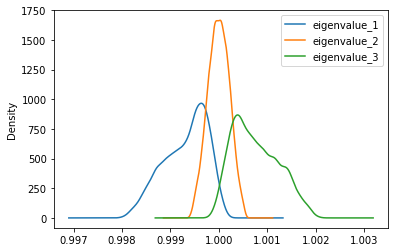

In [65]:
a_c_all_eigs_df.plot.kde()

Next we check the scenarios.
* find non-contractions